Import all necessary modules

In [10]:
import math
import numpy as np
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import csv

Function Dictionary

In [11]:
# Calculate E(z)
def E(z_i, w, omega_m, omega_l):
    omega_k = 1.0 - omega_m - omega_l
    E = np.sqrt(omega_m * (1.0 + z_i)**3 + omega_k * (1.0 + z_i)**2 + omega_l * (1.0+z_i)**(3.0*(1+w)))
    return E;

# Calculate the integral D_C/D_H, store it in an array
def DCDH_int(z_limit, omega_m, omega_l):
    f = lambda z_i: 1.0 / E(z_i, omega_m, omega_l)
    i = integrate.quad(f, 0, z_limit)
    return i[0]

In [12]:
# Proper Motion distance integrals

# proper motion distance for omega_l == 0
def prop_motion_0(z, DMDH, omega_m, omega_l):
    # create the output array DMDH
    DMDH = np.copy(z);

    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(r"$\Omega_k =$ " + str(omega_k))
    print(r"$\Omega_\Mu =$ " + str(omega_m))
    print(r"$\Omega_\Lambda =$ " + str(omega_l))

    # Calculate D_M/D_H for different universe geometries
    # open universe
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        DMDH = 2.0*( 2.0 - omega_m*(1.0-z) - (2-omega_m)*np.sqrt(1.0+omega_m*z) ) / ( omega_m*omega_m*(1.0+z) );

    return DMDH

# proper motion distance for omega_l != 0
def prop_motion(z, DMDH, omega_m, omega_l):
    DMDH = np.copy(z);
    
    # find omega_k = 1 - omega_m - omega_l
    omega_k = 1.0 - omega_m - omega_l
    print(omega_k)
    
    # Calculate D_M/D_H for different universe geometries
    if (omega_k > 1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(omega_k) * np.sinh( np.sqrt(omega_k) * DCDH_int(z[i],omega_m,omega_l) )
    # closed universe
    elif (omega_k < -1.0e-6):
        for i in range(len(z)):
            DMDH[i] = 1/np.sqrt(abs(omega_k)) * np.sin( np.sqrt(abs(omega_k)) * DCDH_int(z[i],omega_m,omega_l) )
    # flat universe
    else:
        for i in range(len(z)):
            DMDH[i] = DCDH_int(z[i], omega_m, omega_l)
    return DMDH

In [13]:
# angular diameter distance
def dist_angdiam(z, DMDH, DADH, omega_m, omega_l):
    DADH = np.copy(z);
    DADH = DMDH / (1.0+z)
    return DADH;

# luminosity distance
def dist_lum(z, DMDH, DLDH, omega_m, omega_l):
    DLDH = np.copy(z)
    DLDH = DMDH * (1.0+z)
    return DLDH;

# distance modulus
def dist_mod(z, D_H, omega_m, omega_l, DMDH):
    # initialize the distance modulus array
    mu = np.copy(z)

    # convert D_H from Mpc to pc
    D_H = D_H * 1.0e6

    # calculate each value of mu array
    #for i in range(len(z)):
        #mu[i] = 5.0 * ( np.log10(1.0+z[i]) + np.log10(DCDH_int(z[i], omega_m, omega_l)) + np.log10(D_H/10) )
    mu = 5.0 * ( np.log10(1.0+z) + np.log10(DMDH) + np.log10(D_H/10) )
    return mu;

# comoving volume element
def com_vol(z, DMDH, DVC, omega_m, omega_l, D_H):
    DVC = np.copy(z)
    for i in range(len(z)):
        DVC[i] = DMDH[i]**2 * D_H**3 / ( E(z[i], omega_m, omega_l) )
    return DVC;

Variable Dictionary

In [14]:
# Constants
omega_k = 0                     # critical density
c = 2.9979e5                    # speed of light (km/s)
omega_m = None                  # mass density parameter
w = None                        # equation of state
omega_l = None                  # energy density
pressure = 0.0                  # pressure of the universe

# Variable dictionary
H = None                        # Hubble constant (km/s/Mpc)
z = None                        # redshift
D_C = None                      # comoving distance, line-of-sight (m)
D_M = None                      # comoving distance, transverse (m)
D_A = None                      # angular diameter distance (m)
D_L = None                      # luminosity distance (m)
V_C = None                      # comoving volume (m^3)
D_H = None                      # Hubble Distance (Mpc)
array_size = None               # size of each array, which is the number of z values
param_text = ""                 # label for the plots

# Output arrays
z = None;                       # Array of input values of z
DMDH = np.array([])             # Array of output values of D_M/D_H
DADH = np.array([])             # Array of output values of D_A/D_H
DLDH = np.array([])             # Array of output values of D_L/D_H
dmod = np.array([])             # distance modulus array
DVC = np.array([])              # comoving volume array
tLtH = np.array([])             # Array of lookback times
age = np.array([])              # Array of ages
dPdz = np.array([])             # dimensionless intersection probability

We draw arrays of corresponding density parameters from Figure 20.

We note that equation of state $w$ and energy density $\Omega_\Lambda$ are related as follows:
$$w = \frac{pressure}{\Omega_\Lambda}$$

In [15]:
# arrays of density parameters
omegam_array = np.array([1.0, 0.05, 0.2])
w_array = np.array([0.0, 0.0, 0.8])
omegal_array = np.copy(w_array)
omegal_array = pressure / w_array

# Note: remove this later
# arrays of density parameters
omegam_array = np.array([1.0, 0.05, 0.2])
omegal_array = np.array([0.0, 0.0, 0.8])

<ipython-input-15-6fd72f42069d>:5: RuntimeWarning: invalid value encountered in true_divide
  omegal_array = pressure / w_array


Take in values

In [16]:
# Take in densities
print("\u03A9_k = 0.0")     # omega_k = 0.0

# Take in Hubble constant
H = 70#float(input("Enter Hubble constant (in km/s/Mpc): "))
D_H = c / H                 # Hubble distance

# Parameters for plot, including the range of redshift values and y-axis
zmin = 0.001
zmax = 2.5
ymin = 0
ymax = None

# Define the array of z-values (redshift)
z = np.linspace(zmin, zmax, 100)

Ω_k = 0.0


Plot the Distance Modulus

Distance Modulus vs Redshift
sne_x
[0.50309, 0.4948, 0.67767, 0.8665, 0.79857, 0.37144, 0.35582, 0.2836, 0.4664, 0.94688, 0.69315, 0.89693, 0.78904, 0.59027, 0.21075, 0.85852, 0.55875, 0.9964, 0.58294, 0.79656, 0.91348, 0.94846, 0.73362, 0.7656, 0.98341, 0.70064, 0.83814, 0.3706, 0.35858, 0.52278, 0.70198, 0.74613, 0.59185, 0.62063, 1.00279, 0.61064, 0.35833, 0.45155, 0.5526, 0.75068, 0.82269, 0.95076, 0.34052, 0.81072, 0.61124, 0.54831, 1.02879, 0.42244, 0.70115, 0.68517, 0.93189, 0.74909, 0.4684, 0.95886, 0.84053, 0.56276, 0.82854, 0.57875, 0.8645, 0.85851, 0.58575, 0.48881, 0.68866, 0.32454, 0.18538, 0.68196, 0.92223, 0.42866, 0.69998, 0.57584, 0.51176, 0.64191, 0.35157, 0.34957, 0.35527, 0.87217, 0.92624, 0.41957, 0.89073, 0.48057, 0.5806, 0.80569, 0.66464, 0.74566, 0.73669, 0.37053, 0.85073, 0.21946, 0.64764, 0.6006, 0.7607, 0.47057, 0.49737, 0.50736, 0.58728, 0.69915, 0.76108, 0.78805, 0.40547, 0.80804, 0.58328, 0.72013, 0.83699, 0.80603, 0.50074, 0.53378, 0.82212, 0.12531, 0.443

TypeError: E() missing 1 required positional argument: 'omega_l'

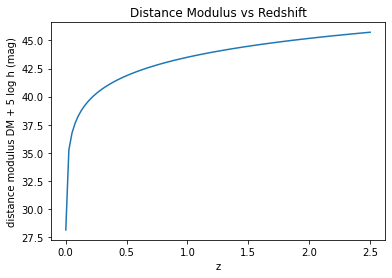

In [17]:
print("Distance Modulus vs Redshift")
plt.title("Distance Modulus vs Redshift")
plt.xlabel("z")
plt.ylabel("distance modulus DM + 5 log h (mag)")

ymin = 0
ymax = 80

# Begin by collecting csv data
sne_x = []
sne_y = []

with open('ps1_data.txt', newline='') as csvfile:
    ps1_data = csv.reader(csvfile, delimiter=' ')
        
    i = 0
    for row in ps1_data:
        if (i > 0):
            sne_x.append(float(row[1]))
            sne_y.append(float(row[4]))
        i+= 1
        
print("sne_x")
print(sne_x)
print("sne_y")

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
        
    mu = dist_mod(z, D_H, omega_m, omega_l, DMDH)
    print("i = " + str(i))
    
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, mu, label=param_text)

plt.scatter(sne_x, sne_y)
plt.axis([zmin, zmax, ymin, ymax])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()

Generate a residual plot by feeding values from sne_x into the prop_motion() function.

In [18]:
res = []                     # list of residuals

# test values of omega_m and omega_l
omega_m = omegam_array[-1]
omega_l = omegal_array[-1]

# Feed the sne_x array into the functions
sne_x = np.array(sne_x)
if (omega_l == 0):
    DMDH = prop_motion_0(sne_x, DMDH, omega_m, omega_l)
else:
    DMDH = prop_motion(sne_x, DMDH, omega_m, omega_l)

# corresponding predicted distance modulus
dm_predicted = dist_mod(sne_x, D_H, omega_m, omega_l, DMDH)

# actual distance modulus
dm_actual = np.array(sne_y)

# calculate residuals
res = dm_actual - dm_predicted

# Find the average residual value
avg_res = np.mean(res)

avg_y = np.copy(z)
for i in range(len(avg_y)):
    avg_y[i] = avg_res

plt.scatter(sne_x, res)
plt.plot(z, avg_y)
plt.xscale('log')
plt.show()

0.0


TypeError: E() missing 1 required positional argument: 'omega_l'

Plot again, this time making the cosmology plot match the scatterplot:

$\Omega_k =$ 0.0
$\Omega_\Mu =$ 1.0
$\Omega_\Lambda =$ 0.0
i = 0
$\Omega_k =$ 0.95
$\Omega_\Mu =$ 0.05
$\Omega_\Lambda =$ 0.0
i = 1
0.0
i = 2


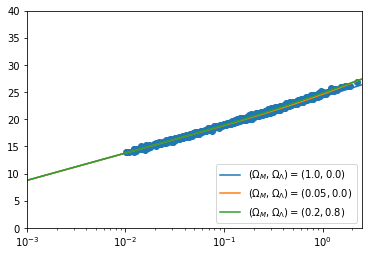

In [33]:
ymax = 40

for i in range(len(omegam_array)):
    omega_m = omegam_array[i]
    omega_l = omegal_array[i]
    if (omega_l == 0):
        DMDH = prop_motion_0(z, DMDH, omega_m, omega_l)
    else:
        DMDH = prop_motion(z, DMDH, omega_m, omega_l)
        
    mu = dist_mod(z, D_H, omega_m, omega_l, DMDH) + avg_res
    print("i = " + str(i))
    
    param_text = r"$\left(\Omega_M, \Omega_\Lambda\right) = " + "(" + str(omega_m) + ", " + str(omega_l) + ")$"
    plt.plot(z, mu, label=param_text)

plt.scatter(sne_x, sne_y)
plt.axis([zmin, zmax, ymin, ymax])
plt.xscale('log')
plt.legend(loc='lower right')
plt.show()